# PreTrain

In [1]:
from model.sswae_dev2_1 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 7

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.429
[2] loss: 0.437
[3] loss: 0.280
[4] loss: 0.198
[5] loss: 0.078
[6] loss: 0.029
[7] loss: 0.015
[8] loss: 0.013
[9] loss: 0.010
[10] loss: 0.007
[11] loss: 0.007
[12] loss: 0.007
[13] loss: 0.006
[14] loss: 0.005
[15] loss: 0.005
[16] loss: 0.002
[17] loss: 0.005
[18] loss: 0.004
[19] loss: 0.004
[20] loss: 0.002


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 7])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

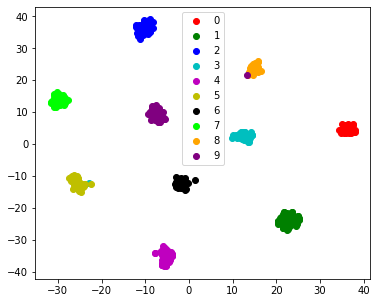

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

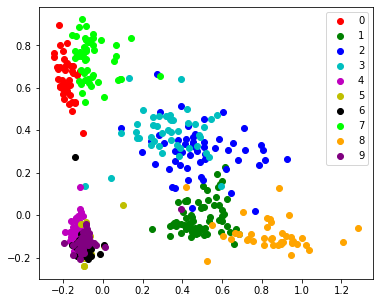

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)
covs = np.zeros((10, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [12]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[-0.1685,  0.4911,  0.4854,  0.3291, -0.1326, -0.0890, -0.1013, -0.0729,
          0.8618, -0.0980],
        [-0.2793,  0.1846,  0.3315, -0.1905,  0.4350, -0.2524,  0.1638, -0.0585,
         -0.2481, -0.2236],
        [ 0.5924, -0.0163,  0.2767,  0.3717, -0.0587, -0.1530, -0.1496,  0.7197,
         -0.1138, -0.1277],
        [-0.1696, -0.0908,  0.3124,  0.3236, -0.2048,  0.6404,  0.0830,  0.2896,
         -0.1162, -0.1054],
        [-0.1777,  0.4733,  0.1143, -0.1931, -0.1578, -0.1682, -0.1535,  0.4464,
         -0.1996,  0.4228],
        [ 0.5193, -0.0642,  0.6111, -0.1511, -0.1983,  0.0443,  0.3990, -0.1568,
         -0.0526, -0.1005],
        [ 0.1238,  0.4122, -0.0982,  0.4210, -0.1254, -0.0565,  0.3544, -0.0578,
         -0.1085, -0.0807]])

In [13]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}.pt')

In [14]:
w2 = torch.tensor((covs.T / (cs - 1)).T)

In [15]:
for i in range(10):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [16]:
f2 = nn.ConvTranspose2d(10, 1, y_dim, bias=False)
f2.weight.data = w2.view(10,1,y_dim,y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}.pt')

# Train

In [17]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_1_13.cfg')

['./config/sswae_dev2_1_13.cfg']

In [18]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 4
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 7
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [01/80]  loss: 2.413556e-01  D: 6.904293e-01  D2: 3.485996e-02  D3: 2.025970e-03
test loss: 1.792420e-01  D: 6.992199e-01  D2: 1.039845e-02  D3: 7.424899e-03


[default |INFO|model.py:1280] [02/80]  loss: 1.697504e-01  D: 7.022978e-01  D2: 5.851385e-03  D3: 1.010088e-02
test loss: 1.538149e-01  D: 6.999006e-01  D2: 3.137035e-03  D3: 8.565090e-03


[default |INFO|model.py:1280] [03/80]  loss: 1.514276e-01  D: 6.961161e-01  D2: 2.039490e-03  D3: 1.244142e-02
test loss: 1.450553e-01  D: 6.459845e-01  D2: 1.466236e-03  D3: 1.871421e-02


[default |INFO|model.py:1280] [04/80]  loss: 1.328756e-01  D: 6.974629e-01  D2: 1.306089e-03  D3: 1.452788e-02
test loss: 1.178900e-01  D: 6.865836e-01  D2: 8.589458e-04  D3: 1.555900e-02


[default |INFO|model.py:1280] [05/80]  loss: 1.077489e-01  D: 6.914052e-01  D2: -1.751455e-04  D3: 1.334227e-02
test loss: 9.675711e-02  D: 6.723636e-01  D2: -1.555243e-03  D3: 1.580474e-02


[default |INFO|model.py:1280] [06/80]  loss: 9.821312e-02  D: 6.923629e-01  D2: -1.996482e-03  D3: 1.243235e-02
test loss: 8.761064e-02  D: 7.010162e-01  D2: -2.648163e-03  D3: 1.427308e-02


[default |INFO|model.py:1280] [07/80]  loss: 9.142768e-02  D: 6.943659e-01  D2: -2.103661e-03  D3: 1.312076e-02
test loss: 8.556788e-02  D: 7.030101e-01  D2: -2.642088e-03  D3: 1.314061e-02


[default |INFO|model.py:1280] [08/80]  loss: 8.532707e-02  D: 6.943209e-01  D2: -2.379999e-03  D3: 1.415243e-02
test loss: 7.885198e-02  D: 6.879658e-01  D2: -2.940292e-03  D3: 1.381173e-02


[default |INFO|model.py:1280] [09/80]  loss: 8.172746e-02  D: 6.931801e-01  D2: -2.926796e-03  D3: 1.438442e-02
test loss: 7.755701e-02  D: 6.881237e-01  D2: -2.938223e-03  D3: 1.396170e-02


[default |INFO|model.py:1280] [10/80]  loss: 7.894879e-02  D: 6.944104e-01  D2: -3.028285e-03  D3: 1.388797e-02
test loss: 7.594218e-02  D: 6.867006e-01  D2: -3.419056e-03  D3: 1.345738e-02


[default |INFO|model.py:1280] [11/80]  loss: 7.518702e-02  D: 6.925150e-01  D2: -3.458401e-03  D3: 1.428078e-02
test loss: 7.274073e-02  D: 6.819058e-01  D2: -3.217297e-03  D3: 1.341839e-02


[default |INFO|model.py:1280] [12/80]  loss: 7.187264e-02  D: 6.932334e-01  D2: -3.862446e-03  D3: 1.413514e-02
test loss: 7.060408e-02  D: 7.001497e-01  D2: -4.180794e-03  D3: 1.580251e-02


[default |INFO|model.py:1280] [13/80]  loss: 6.925440e-02  D: 6.941031e-01  D2: -3.916014e-03  D3: 1.393638e-02
test loss: 6.854166e-02  D: 6.796753e-01  D2: -4.232721e-03  D3: 1.322196e-02


[default |INFO|model.py:1280] [14/80]  loss: 6.770504e-02  D: 6.929310e-01  D2: -4.186207e-03  D3: 1.370169e-02
test loss: 6.786150e-02  D: 6.954848e-01  D2: -4.030647e-03  D3: 1.343273e-02


[default |INFO|model.py:1280] [15/80]  loss: 6.761941e-02  D: 6.931812e-01  D2: -4.293963e-03  D3: 1.383979e-02
test loss: 6.676186e-02  D: 6.985834e-01  D2: -5.055323e-03  D3: 1.292074e-02


[default |INFO|model.py:1280] [16/80]  loss: 6.515970e-02  D: 6.932849e-01  D2: -4.494855e-03  D3: 1.377360e-02
test loss: 6.389627e-02  D: 6.952054e-01  D2: -4.535465e-03  D3: 1.277031e-02


[default |INFO|model.py:1280] [17/80]  loss: 6.408548e-02  D: 6.934547e-01  D2: -4.637399e-03  D3: 1.362807e-02
test loss: 6.231542e-02  D: 6.931733e-01  D2: -5.171432e-03  D3: 1.356069e-02


[default |INFO|model.py:1280] [18/80]  loss: 6.311533e-02  D: 6.936974e-01  D2: -4.706933e-03  D3: 1.367716e-02
test loss: 6.146371e-02  D: 6.915154e-01  D2: -4.365816e-03  D3: 1.414741e-02


[default |INFO|model.py:1280] [19/80]  loss: 6.251237e-02  D: 6.936939e-01  D2: -4.876698e-03  D3: 1.355165e-02
test loss: 6.141852e-02  D: 7.116960e-01  D2: -4.836206e-03  D3: 1.308935e-02


[default |INFO|model.py:1280] [20/80]  loss: 6.262746e-02  D: 6.949026e-01  D2: -5.011555e-03  D3: 1.300754e-02
test loss: 6.494147e-02  D: 6.896004e-01  D2: -4.990845e-03  D3: 1.287567e-02


[default |INFO|model.py:1280] [21/80]  loss: 6.369825e-02  D: 6.930278e-01  D2: -4.971182e-03  D3: 1.283650e-02
test loss: 6.135317e-02  D: 6.934651e-01  D2: -5.362148e-03  D3: 1.269071e-02


[default |INFO|model.py:1280] [22/80]  loss: 6.158660e-02  D: 6.933054e-01  D2: -5.212502e-03  D3: 1.335017e-02
test loss: 6.114673e-02  D: 6.936699e-01  D2: -6.010542e-03  D3: 1.326702e-02


[default |INFO|model.py:1280] [23/80]  loss: 6.153279e-02  D: 6.933789e-01  D2: -5.267987e-03  D3: 1.316654e-02
test loss: 6.122786e-02  D: 7.069257e-01  D2: -5.479059e-03  D3: 1.438148e-02


[default |INFO|model.py:1280] [24/80]  loss: 6.107921e-02  D: 6.934084e-01  D2: -5.404795e-03  D3: 1.326118e-02
test loss: 6.171044e-02  D: 6.822901e-01  D2: -5.882740e-03  D3: 1.375583e-02


[default |INFO|model.py:1280] [25/80]  loss: 6.164203e-02  D: 6.940750e-01  D2: -5.703185e-03  D3: 1.257965e-02
test loss: 6.222131e-02  D: 6.962188e-01  D2: -5.380821e-03  D3: 9.982122e-03


[default |INFO|model.py:1280] [26/80]  loss: 6.051019e-02  D: 6.936404e-01  D2: -5.885413e-03  D3: 1.269265e-02
test loss: 6.252839e-02  D: 6.961840e-01  D2: -5.471497e-03  D3: 1.527174e-02


[default |INFO|model.py:1280] [27/80]  loss: 5.884482e-02  D: 6.935107e-01  D2: -5.857676e-03  D3: 1.316488e-02
test loss: 5.940228e-02  D: 6.843089e-01  D2: -6.046648e-03  D3: 1.225087e-02


[default |INFO|model.py:1280] [28/80]  loss: 5.812157e-02  D: 6.933858e-01  D2: -6.138099e-03  D3: 1.303270e-02
test loss: 5.826178e-02  D: 6.866138e-01  D2: -5.758820e-03  D3: 1.278849e-02


[default |INFO|model.py:1280] [29/80]  loss: 5.869267e-02  D: 6.933745e-01  D2: -6.142872e-03  D3: 1.297201e-02
test loss: 5.860219e-02  D: 7.009989e-01  D2: -6.263599e-03  D3: 1.241833e-02


[default |INFO|model.py:1280] [30/80]  loss: 5.848829e-02  D: 6.932561e-01  D2: -6.041859e-03  D3: 1.289101e-02
test loss: 6.104732e-02  D: 7.012069e-01  D2: -6.274319e-03  D3: 1.152786e-02


[default |INFO|model.py:1280] [31/80]  loss: 5.920739e-02  D: 6.936429e-01  D2: -6.459274e-03  D3: 1.257787e-02
test loss: 5.787745e-02  D: 7.002912e-01  D2: -5.463047e-03  D3: 1.190993e-02


[default |INFO|model.py:1280] [32/80]  loss: 5.827160e-02  D: 6.935039e-01  D2: -6.362335e-03  D3: 1.260497e-02
test loss: 5.917032e-02  D: 6.895908e-01  D2: -6.969013e-03  D3: 1.085920e-02


[default |INFO|model.py:1280] [33/80]  loss: 5.802168e-02  D: 6.936234e-01  D2: -6.682380e-03  D3: 1.256921e-02
test loss: 6.173223e-02  D: 6.956394e-01  D2: -6.170931e-03  D3: 1.087985e-02


[default |INFO|model.py:1280] [34/80]  loss: 5.782694e-02  D: 6.934796e-01  D2: -6.605428e-03  D3: 1.274717e-02
test loss: 5.924640e-02  D: 6.962587e-01  D2: -6.675072e-03  D3: 1.205731e-02


[default |INFO|model.py:1280] [35/80]  loss: 5.797270e-02  D: 6.935806e-01  D2: -6.706100e-03  D3: 1.258786e-02
test loss: 5.974108e-02  D: 6.920046e-01  D2: -6.462059e-03  D3: 1.496880e-02


[default |INFO|model.py:1280] [36/80]  loss: 5.711925e-02  D: 6.931526e-01  D2: -6.884386e-03  D3: 1.250877e-02
test loss: 5.541731e-02  D: 6.942278e-01  D2: -7.006702e-03  D3: 1.232030e-02


[default |INFO|model.py:1280] [37/80]  loss: 5.597234e-02  D: 6.933726e-01  D2: -6.950412e-03  D3: 1.271036e-02
test loss: 5.644828e-02  D: 6.938980e-01  D2: -6.707640e-03  D3: 1.322341e-02


[default |INFO|model.py:1280] [38/80]  loss: 5.561571e-02  D: 6.934984e-01  D2: -6.893522e-03  D3: 1.268927e-02
test loss: 5.858595e-02  D: 7.047242e-01  D2: -7.092752e-03  D3: 1.194843e-02


[default |INFO|model.py:1280] [39/80]  loss: 5.596377e-02  D: 6.932819e-01  D2: -7.211035e-03  D3: 1.249720e-02
test loss: 5.642690e-02  D: 6.836489e-01  D2: -7.326689e-03  D3: 1.269758e-02


[default |INFO|model.py:1280] [40/80]  loss: 5.713885e-02  D: 6.933354e-01  D2: -7.253793e-03  D3: 1.228530e-02
test loss: 5.804088e-02  D: 6.934608e-01  D2: -7.555723e-03  D3: 1.124667e-02


[default |INFO|model.py:1280] [41/80]  loss: 5.647842e-02  D: 6.932209e-01  D2: -7.369871e-03  D3: 1.247114e-02
test loss: 5.823735e-02  D: 6.960612e-01  D2: -7.405167e-03  D3: 1.193267e-02


[default |INFO|model.py:1280] [42/80]  loss: 5.646041e-02  D: 6.932715e-01  D2: -7.352991e-03  D3: 1.239503e-02
test loss: 5.932158e-02  D: 6.945550e-01  D2: -7.179899e-03  D3: 1.375785e-02


[default |INFO|model.py:1280] [43/80]  loss: 5.788373e-02  D: 6.934326e-01  D2: -7.371213e-03  D3: 1.197091e-02
test loss: 6.200688e-02  D: 6.962594e-01  D2: -7.165594e-03  D3: 1.611181e-02


[default |INFO|model.py:1280] [44/80]  loss: 5.614302e-02  D: 6.935967e-01  D2: -7.371731e-03  D3: 1.227582e-02
test loss: 5.752193e-02  D: 6.972803e-01  D2: -7.305813e-03  D3: 1.162083e-02


[default |INFO|model.py:1280] [45/80]  loss: 5.624422e-02  D: 6.935786e-01  D2: -7.555761e-03  D3: 1.219993e-02
test loss: 5.752418e-02  D: 6.974340e-01  D2: -7.931976e-03  D3: 1.179980e-02


[default |INFO|model.py:1280] [46/80]  loss: 5.658476e-02  D: 6.932832e-01  D2: -7.512695e-03  D3: 1.215028e-02
test loss: 5.708813e-02  D: 7.012428e-01  D2: -7.621546e-03  D3: 1.241084e-02


[default |INFO|model.py:1280] [47/80]  loss: 5.575264e-02  D: 6.932190e-01  D2: -7.799501e-03  D3: 1.224647e-02
test loss: 5.777344e-02  D: 6.908400e-01  D2: -7.460070e-03  D3: 1.309350e-02


[default |INFO|model.py:1280] [48/80]  loss: 5.714533e-02  D: 6.935976e-01  D2: -7.638559e-03  D3: 1.191847e-02
test loss: 5.764681e-02  D: 7.077533e-01  D2: -7.439795e-03  D3: 1.158866e-02


[default |INFO|model.py:1280] [49/80]  loss: 5.566683e-02  D: 6.932230e-01  D2: -7.697722e-03  D3: 1.212113e-02
test loss: 5.717434e-02  D: 6.968605e-01  D2: -7.159491e-03  D3: 1.199916e-02


[default |INFO|model.py:1280] [50/80]  loss: 5.603017e-02  D: 6.932726e-01  D2: -7.696743e-03  D3: 1.224719e-02
test loss: 5.720499e-02  D: 6.919399e-01  D2: -7.586508e-03  D3: 1.264767e-02


[default |INFO|model.py:1280] [51/80]  loss: 5.563258e-02  D: 6.932494e-01  D2: -7.929150e-03  D3: 1.213731e-02
test loss: 5.831157e-02  D: 6.887767e-01  D2: -7.932196e-03  D3: 1.078588e-02


[default |INFO|model.py:1280] [52/80]  loss: 5.578167e-02  D: 6.935548e-01  D2: -7.888734e-03  D3: 1.194341e-02
test loss: 5.845682e-02  D: 6.976108e-01  D2: -7.891359e-03  D3: 1.148163e-02


[default |INFO|model.py:1280] [53/80]  loss: 5.510136e-02  D: 6.932602e-01  D2: -8.015787e-03  D3: 1.219760e-02
test loss: 5.530724e-02  D: 6.949064e-01  D2: -8.240595e-03  D3: 1.256791e-02


[default |INFO|model.py:1280] [54/80]  loss: 5.539200e-02  D: 6.930810e-01  D2: -8.015048e-03  D3: 1.212915e-02
test loss: 5.661820e-02  D: 6.993331e-01  D2: -8.257217e-03  D3: 1.189246e-02


[default |INFO|model.py:1280] [55/80]  loss: 5.560951e-02  D: 6.938988e-01  D2: -8.153036e-03  D3: 1.192813e-02
test loss: 5.751597e-02  D: 6.960551e-01  D2: -8.220863e-03  D3: 1.126129e-02


[default |INFO|model.py:1280] [56/80]  loss: 5.492264e-02  D: 6.931245e-01  D2: -8.105559e-03  D3: 1.213688e-02
test loss: 5.771882e-02  D: 6.886505e-01  D2: -8.571692e-03  D3: 1.322962e-02


[default |INFO|model.py:1280] [57/80]  loss: 5.529487e-02  D: 6.928695e-01  D2: -8.136991e-03  D3: 1.206587e-02
test loss: 5.783084e-02  D: 6.934410e-01  D2: -8.121386e-03  D3: 1.148318e-02


[default |INFO|model.py:1280] [58/80]  loss: 5.558914e-02  D: 6.937617e-01  D2: -8.270491e-03  D3: 1.176763e-02
test loss: 5.711148e-02  D: 7.101882e-01  D2: -7.374344e-03  D3: 1.286806e-02


[default |INFO|model.py:1280] [59/80]  loss: 5.637731e-02  D: 6.937315e-01  D2: -8.275328e-03  D3: 1.185576e-02
test loss: 5.951540e-02  D: 7.086596e-01  D2: -8.214674e-03  D3: 9.433840e-03


[default |INFO|model.py:1280] [60/80]  loss: 5.514211e-02  D: 6.929218e-01  D2: -8.197721e-03  D3: 1.205379e-02
test loss: 5.705673e-02  D: 6.943909e-01  D2: -8.558207e-03  D3: 1.149175e-02


[default |INFO|model.py:1280] [61/80]  loss: 5.409989e-02  D: 6.930688e-01  D2: -8.419690e-03  D3: 1.196979e-02
test loss: 5.709199e-02  D: 6.861074e-01  D2: -7.889700e-03  D3: 1.121219e-02


[default |INFO|model.py:1280] [62/80]  loss: 5.412780e-02  D: 6.930871e-01  D2: -8.470901e-03  D3: 1.196253e-02
test loss: 5.723412e-02  D: 6.967713e-01  D2: -8.459520e-03  D3: 1.032658e-02


[default |INFO|model.py:1280] [63/80]  loss: 5.471795e-02  D: 6.931166e-01  D2: -8.386060e-03  D3: 1.199416e-02
test loss: 5.731723e-02  D: 6.915264e-01  D2: -8.255749e-03  D3: 1.177731e-02


[default |INFO|model.py:1280] [64/80]  loss: 5.464791e-02  D: 6.935093e-01  D2: -8.424131e-03  D3: 1.181639e-02
test loss: 5.581713e-02  D: 7.008864e-01  D2: -8.499832e-03  D3: 1.178675e-02


[default |INFO|model.py:1280] [65/80]  loss: 5.409719e-02  D: 6.931690e-01  D2: -8.545893e-03  D3: 1.198422e-02
test loss: 5.771191e-02  D: 6.921977e-01  D2: -8.699265e-03  D3: 1.103921e-02


[default |INFO|model.py:1280] [66/80]  loss: 5.421727e-02  D: 6.935208e-01  D2: -8.620559e-03  D3: 1.187593e-02
test loss: 5.666357e-02  D: 7.009156e-01  D2: -8.472843e-03  D3: 1.187095e-02


[default |INFO|model.py:1280] [67/80]  loss: 5.400444e-02  D: 6.929391e-01  D2: -8.514287e-03  D3: 1.201926e-02
test loss: 5.715330e-02  D: 6.945250e-01  D2: -8.592091e-03  D3: 1.153525e-02


[default |INFO|model.py:1280] [68/80]  loss: 5.396978e-02  D: 6.933154e-01  D2: -8.611598e-03  D3: 1.182602e-02
test loss: 5.690423e-02  D: 6.985983e-01  D2: -8.555546e-03  D3: 1.084449e-02


[default |INFO|model.py:1280] [69/80]  loss: 5.434807e-02  D: 6.932000e-01  D2: -8.603045e-03  D3: 1.174055e-02
test loss: 5.835087e-02  D: 6.901149e-01  D2: -8.573046e-03  D3: 1.406802e-02


[default |INFO|model.py:1280] [70/80]  loss: 5.445280e-02  D: 6.928317e-01  D2: -8.609311e-03  D3: 1.171643e-02
test loss: 5.663411e-02  D: 6.810471e-01  D2: -8.080664e-03  D3: 1.211629e-02


[default |INFO|model.py:1280] [71/80]  loss: 5.346416e-02  D: 6.934273e-01  D2: -8.748436e-03  D3: 1.170489e-02
test loss: 5.710485e-02  D: 6.821863e-01  D2: -8.534269e-03  D3: 1.255972e-02


[default |INFO|model.py:1280] [72/80]  loss: 5.442289e-02  D: 6.929341e-01  D2: -8.772289e-03  D3: 1.171568e-02
test loss: 5.741768e-02  D: 6.888186e-01  D2: -8.593740e-03  D3: 1.139209e-02


[default |INFO|model.py:1280] [73/80]  loss: 5.314979e-02  D: 6.934614e-01  D2: -8.810568e-03  D3: 1.175913e-02
test loss: 5.740536e-02  D: 6.858423e-01  D2: -9.045143e-03  D3: 1.262440e-02


[default |INFO|model.py:1280] [74/80]  loss: 5.314888e-02  D: 6.932353e-01  D2: -8.833213e-03  D3: 1.187070e-02
test loss: 5.607592e-02  D: 6.922654e-01  D2: -8.663597e-03  D3: 1.173516e-02


[default |INFO|model.py:1280] [75/80]  loss: 5.414881e-02  D: 6.931714e-01  D2: -8.822227e-03  D3: 1.171564e-02
test loss: 5.458863e-02  D: 6.954351e-01  D2: -8.805256e-03  D3: 1.157347e-02


[default |INFO|model.py:1280] [76/80]  loss: 5.355125e-02  D: 6.933454e-01  D2: -8.798601e-03  D3: 1.166926e-02
test loss: 5.698476e-02  D: 6.860154e-01  D2: -8.651686e-03  D3: 1.097724e-02


[default |INFO|model.py:1280] [77/80]  loss: 5.385259e-02  D: 6.929895e-01  D2: -8.865549e-03  D3: 1.155965e-02
test loss: 5.714374e-02  D: 7.026683e-01  D2: -8.845634e-03  D3: 1.153424e-02


[default |INFO|model.py:1280] [78/80]  loss: 5.295503e-02  D: 6.935565e-01  D2: -8.918745e-03  D3: 1.179763e-02
test loss: 5.588629e-02  D: 6.981413e-01  D2: -8.848305e-03  D3: 1.176020e-02


[default |INFO|model.py:1280] [79/80]  loss: 5.253603e-02  D: 6.932577e-01  D2: -8.990151e-03  D3: 1.173081e-02
test loss: 5.464577e-02  D: 6.938658e-01  D2: -8.955688e-03  D3: 1.219033e-02


[default |INFO|model.py:1280] [80/80]  loss: 5.294969e-02  D: 6.933771e-01  D2: -8.927201e-03  D3: 1.184169e-02
test loss: 5.587825e-02  D: 6.887255e-01  D2: -8.945732e-03  D3: 1.150531e-02


[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 2998.970s


# Test

In [19]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [20]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [21]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

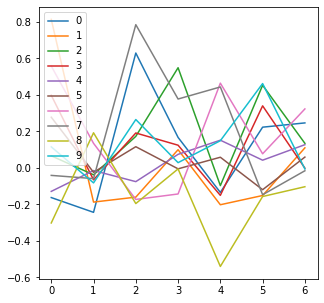

In [22]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

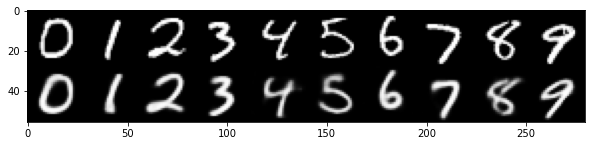

In [23]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [24]:
from XAE.sampler import gaus

exn = 5

In [25]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

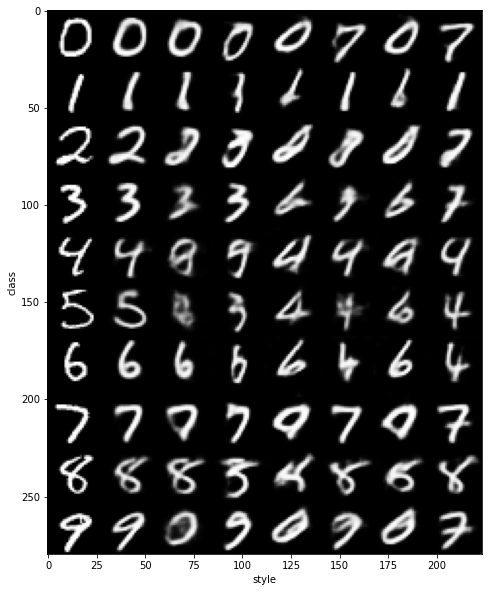

In [26]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [27]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

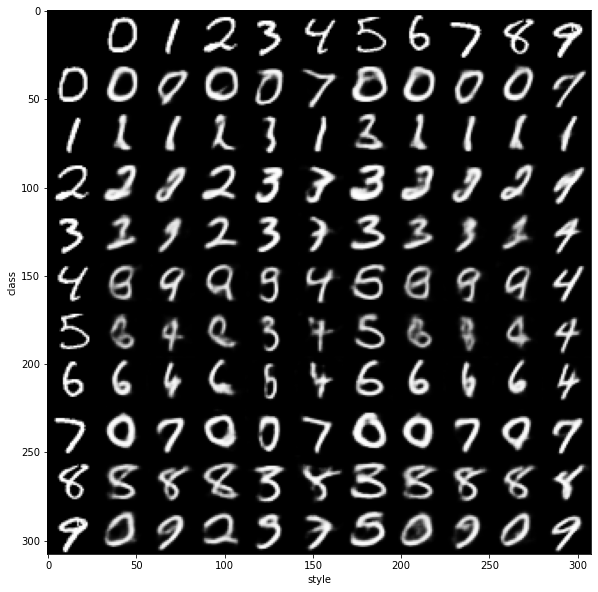

In [28]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()